In [1]:
import os
os.chdir('../')

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import collections
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm

from concepts import concept_instances
from sk_probing import train_binary, train_non_binary
from utils import load_game_data, load_q_network_device

In [3]:
max_data_size = 1000
max_iter = 200
k_fold = 5
num_reg = 5

In [4]:
models_path = "../runs/20231107-224748/models/"
models = os.listdir(models_path)
# get num steps from file name
models = [(f, int(f.split('_')[1].replace('.pt',''))) for f in models if f.endswith(".pt")]
# sort on the number of steps
models.sort(key=lambda x: x[1])

In [5]:
game_data = load_game_data()
for concept in concept_instances.values():
    concept.prepare_data(game_data, max_size=max_data_size)

In [6]:
'''
test_concepts = ['ball left for paddle (b)', 'ball paddle distance']
concept_instances_limited = {}
for concept in test_concepts:
    print(concept, concept_instances[concept])
    concept_instances_limited[concept] = concept_instances[concept]

concept_instances = concept_instances_limited
'''

"\ntest_concepts = ['ball left for paddle (b)', 'ball paddle distance']\nconcept_instances_limited = {}\nfor concept in test_concepts:\n    print(concept, concept_instances[concept])\n    concept_instances_limited[concept] = concept_instances[concept]\n\nconcept_instances = concept_instances_limited\n"

In [7]:
layers = [0,1,2,3,4,5,6,7,8]
train_steps = [m[1] for m in models]
scores = {}

# setup 3d data structures for plotting
for concept in concept_instances.values():
    scores[concept.name] = {}
    x, y = np.meshgrid(train_steps, layers)
    scores[concept.name]['x'] = x
    scores[concept.name]['y'] = y
    scores[concept.name]['z'] = np.zeros((len(layers), len(train_steps)))

In [8]:
# calculate test accuracy for each point: (concept, training_step, layer)
for model_name in models:
    model, steps = model_name
    steps_index = train_steps.index(steps)
    q_network, device = load_q_network_device(models_path + model)
    print("Probing model: ", model)
    for concept in concept_instances.values():
        _, train_acts_dict = q_network(torch.tensor(concept.train_obs).to(device), return_acts=True)
        _, test_acts_dict = q_network(torch.tensor(concept.test_obs).to(device), return_acts=True)
        train_values = concept.train_values
        test_values = concept.test_values

        for layer_index, layer in enumerate(layers):
            train_acts = train_acts_dict[str(layer)].cpu().detach().numpy()
            test_acts = test_acts_dict[str(layer)].cpu().detach().numpy()
            train_acts = train_acts.reshape(len(train_acts), -1)
            test_acts = test_acts.reshape(len(test_acts), -1)

            if concept.binary:
                reg, score = train_binary(train_acts, train_values, test_acts, test_values, max_iter=max_iter, k_fold=k_fold, num_reg=num_reg)
            else:
                reg, score = train_non_binary(train_acts, train_values, test_acts, test_values, max_iter=max_iter, k_fold=k_fold, num_reg=num_reg)
            scores[concept.name]['z'][layer_index][steps_index] = score

Probing model:  model_0.pt
Probing model:  model_5.pt
Probing model:  model_35.pt
Probing model:  model_215.pt
Probing model:  model_1291.pt
Probing model:  model_7742.pt
Probing model:  model_46415.pt
Probing model:  model_278255.pt
Probing model:  model_1668100.pt
Probing model:  model_10000000.pt


In [9]:
for concept in concept_instances.values():
    np.save(f'../data/concept evolution/{concept.name}.npy', scores[concept.name])

In [10]:
def load_scores():
    scores = {}
    for concept in concept_instances.values():
        scores[concept.name] = np.load(f'../data/concept evolution/{concept.name}.npy', allow_pickle=True).item()
    return scores

In [11]:
# Do the same but for linear regression on observation (not activations)
input_score = {}
for concept in concept_instances.values():
    train_obs = concept.train_obs.reshape(len(concept.train_obs), -1)
    test_obs = concept.test_obs.reshape(len(concept.test_obs), -1)
    if concept.binary:
        reg, score = train_binary(train_obs, concept.train_values, test_obs, concept.test_values, max_iter=max_iter, k_fold=k_fold, num_reg=num_reg)
    else:
        reg, score = train_non_binary(train_obs, concept.train_values, test_obs, concept.test_values, max_iter=max_iter, k_fold=k_fold, num_reg=num_reg)
    input_score[concept.name] = max(0, score)
    print(concept.name, score)

ball y 0.34485416777161504
ball x 0.36616991004491295
ball low (b) 0.5900000000000001
ball collision (b) 0.45999999999999996
ball going right (b) 0.25
ball going left (b) 0.22999999999999998
ball going up (b) 0.3600000000000001
ball going down (b) 0.27
ball speed 0.3649244441812153
paddle x 0.9971723869920954
ball left for paddle (b) 0.41999999999999993
ball right for paddle (b) 0.44999999999999996
ball above paddle (b) 0.32000000000000006
ball paddle distance 0.5032360663964783
lives 0.9971861225641968
last life (b) 1.0
losing life (b) 0.7472527472527473
random (b) 0.10000000000000009
brick hit (b) 0.53
bricks hit 0.9981556514927666


### Plot

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


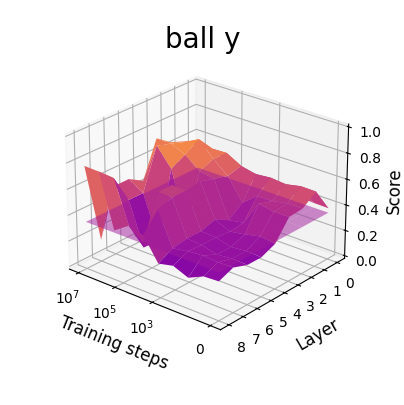

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


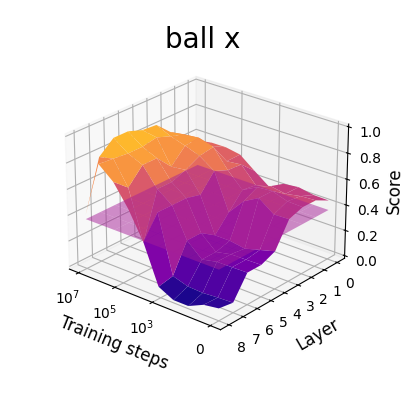

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


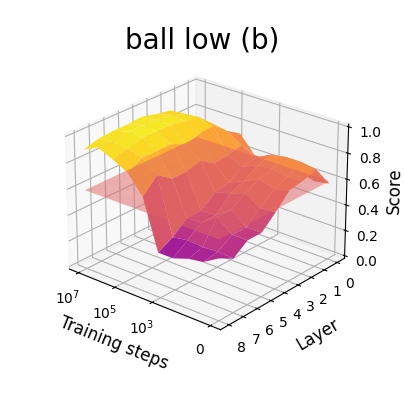

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


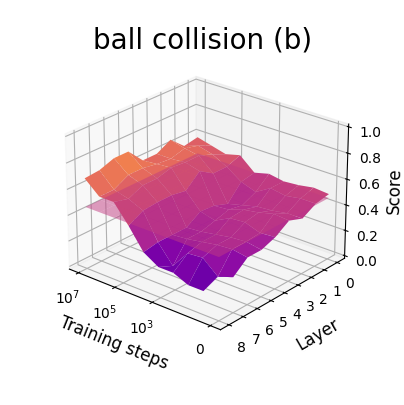

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


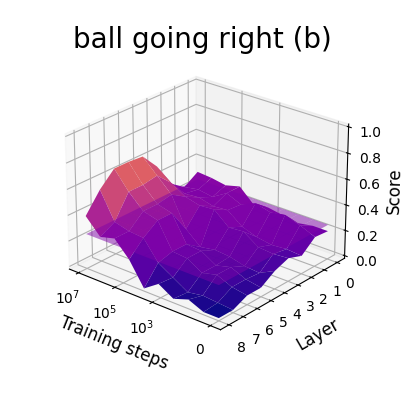

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


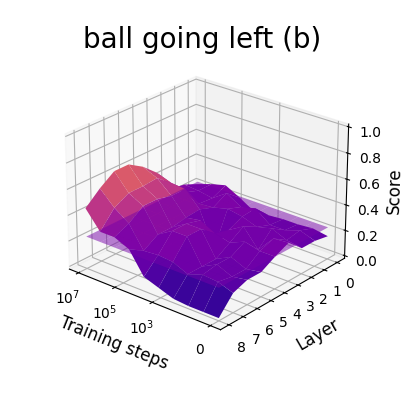

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


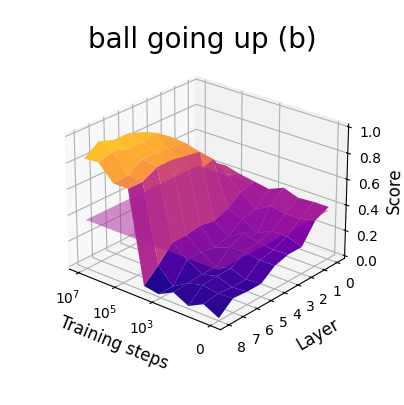

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


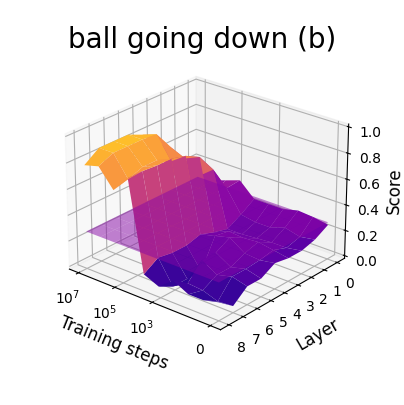

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


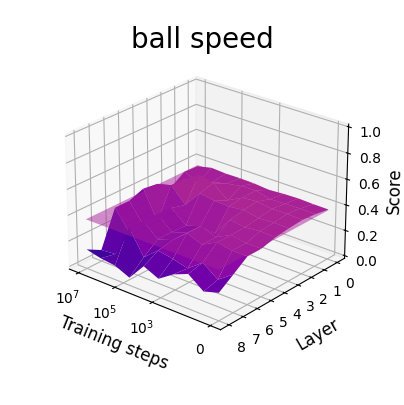

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


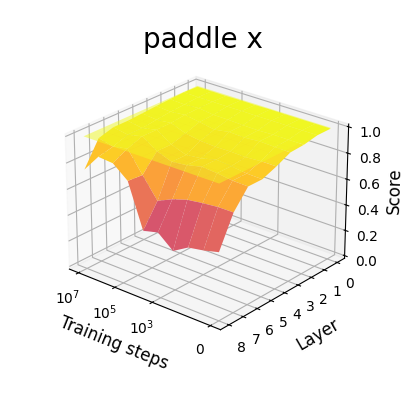

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


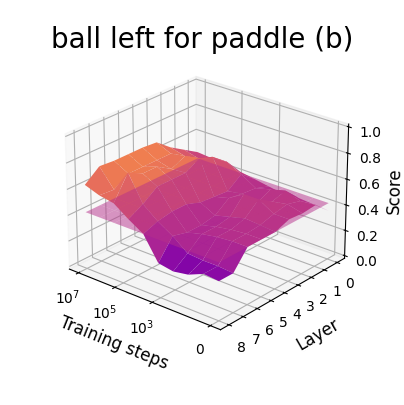

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


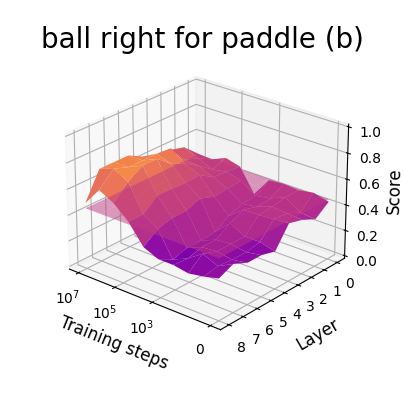

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


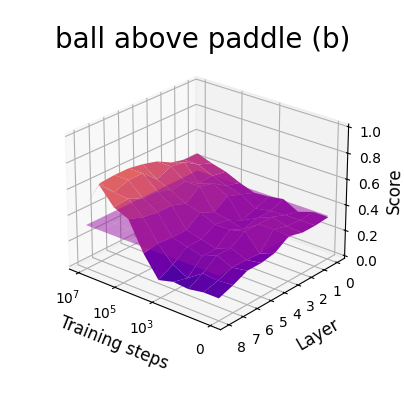

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


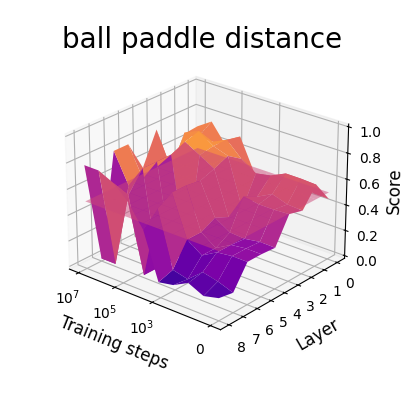

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


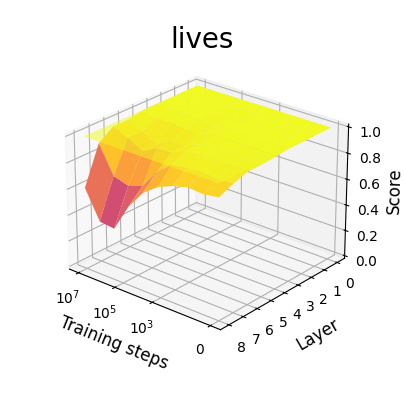

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


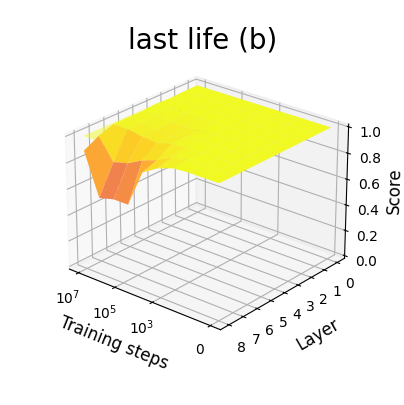

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


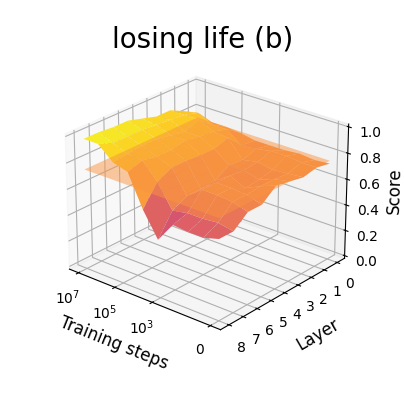

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


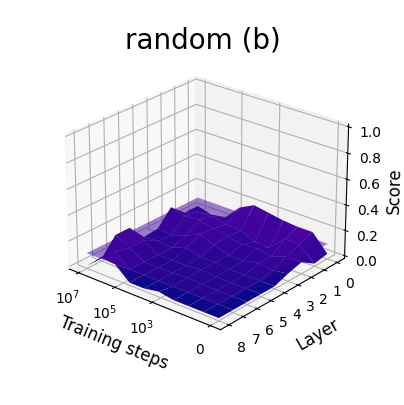

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


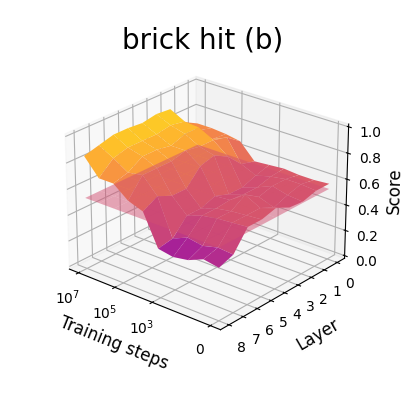

/tmp/ipykernel_12749/1365001789.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


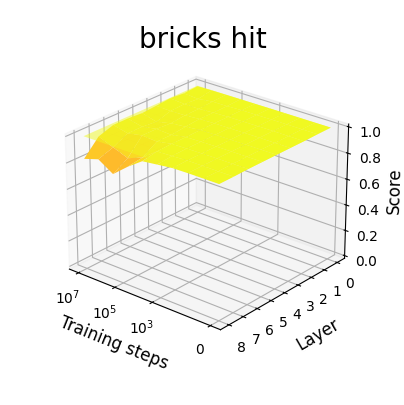

In [12]:
train_steps = np.array(train_steps)
# surface plot accuracies, log10 scale for training steps
for concept in concept_instances.values():
    data = scores[concept.name]
    z = scores[concept.name]['z']
    z_input = np.full(z.shape, input_score[concept.name])

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection='3d')
    # ax.set_title(f'{concept.name}', fontsize=20, pad=-20)
    ax.text2D(0.5, 0.9, f'{concept.name}', transform=ax.transAxes, ha='center', fontsize=20)
    ax.view_init(elev=25, azim=-230)
    ax.plot_surface(np.log10(data['x']+1), data['y'], z_input, vmin=0, vmax=1, alpha=0.5, cmap=cm.plasma)
    ax.plot_surface(np.log10(data['x']+1), data['y'], np.maximum(0, z), vmin=0, vmax=1, cmap=cm.plasma)

    ax.set_xlabel('Training steps', fontsize=12, labelpad=10)
    ax.set_xticks(np.log10([1, 10**3, 10**5, 10**7]))
    ax.set_xticklabels(['$0$', '$10^3$', '$10^5$', '$10^7$'])

    ax.set_ylabel('Layer', fontsize=12, labelpad=10)
    ax.set_yticks(layers)
    ax.set_yticklabels(layers)
    ax.set_zlabel('Score', fontsize=12)
    ax.set_box_aspect(aspect=None, zoom=0.8)

    ax.set_zlim(0, 1)
    plt.savefig(f'../figures/concept evolution/{concept.name}.png', bbox_inches='tight')

    plt.show()